# Unsupervised Analysis: Comprehensive Study of Urban Morphology and Environment

This notebook provides a deep dive into the unsupervised learning analysis of the Geneva dataset. We explore the structural relationships between Environmental Quality (EQ) and Urban Morphology using a suite of advanced techniques.

**Objectives**
1.  **Dimensionality Reduction**: Understand the complexity of our data using PCA.
2.  **Latent Correlation**: Quantify the link between environment and form using CCA and interpret the drivers.
3.  **Clustering**: Identify distinct typologies of neighborhoods. **Note**: Given the small dataset size, we prioritize Hierarchical Clustering over density-based methods.
4.  **Manifold Visualization**: Visualize the high-dimensional landscape.
5.  **Surrogate Validation**: Test if environmental features can predict morphological structure, interpreted via **SHAP**.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import AgglomerativeClustering

# Add project root to path
current_dir = Path.cwd()
if str(current_dir.parent) not in sys.path:
    sys.path.append(str(current_dir.parent))

# Imports from the unsupervised module
from src.unsupervised.data_loader import load_and_split_data
from src.unsupervised.unsupervised import UnsupervisedAnalyzer
from src.unsupervised.surrogate import SurrogateModel

%matplotlib inline
sns.set_theme(style="whitegrid")

c:\Users\boiar\miniconda3\envs\notebook-run\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading and Preprocessing

We load the integrated data and split it into two views:
- **X (Environment)**: Noise, Pollution, Solar, etc.
- **Y (Morphology)**: Density, Heights, Road Networks, etc.
- **Meta**: Typology labels and pre-computed PCs.

The data is standardized (mean=0, std=1) to ensure fair comparison in distance-based algorithms.

In [2]:
data_path = current_dir.parent / "data" / "morphology_data_integrated.csv"
X, Y, meta = load_and_split_data(data_path)

print(f"Loaded {X.shape[0]} samples.")
print(f"Environmental Features ({X.shape[1]}): {X.columns.tolist()}")
print(f"Morphological Features ({Y.shape[1]}): {Y.columns.tolist()}")

Loaded 240 samples.
Environmental Features (8): ['lst_mean', 'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m', 'noisenight']
Morphological Features (13): ['building_height', 'height_varability', 'sky_view_factor', 'frontal_area_index', 'water_cover_fraction', 'impervious_surface_cover_fraction', 'building_cover_fraction', 'pervious_surface_cover_fraction', 'aspect_ratio', 'intersections', 'length_primary_road', 'length_secondary_road', 'length_railway']


## 2. Principal Component Analysis (PCA)

Quick check of the explained variance to understand dimensionality.

PCA on Environment (X):
PCA: 4 components explain 95.52% of variance.


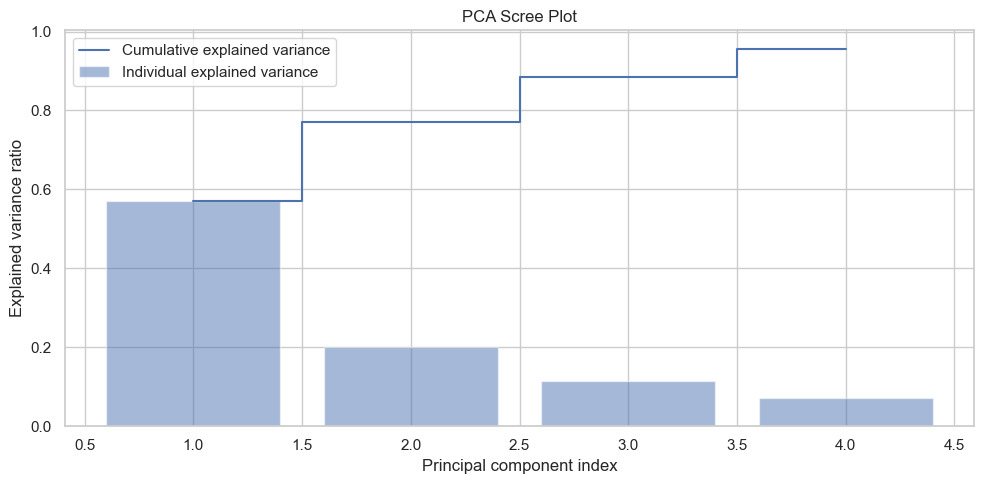

PCA on Morphology (Y):
PCA: 7 components explain 96.17% of variance.


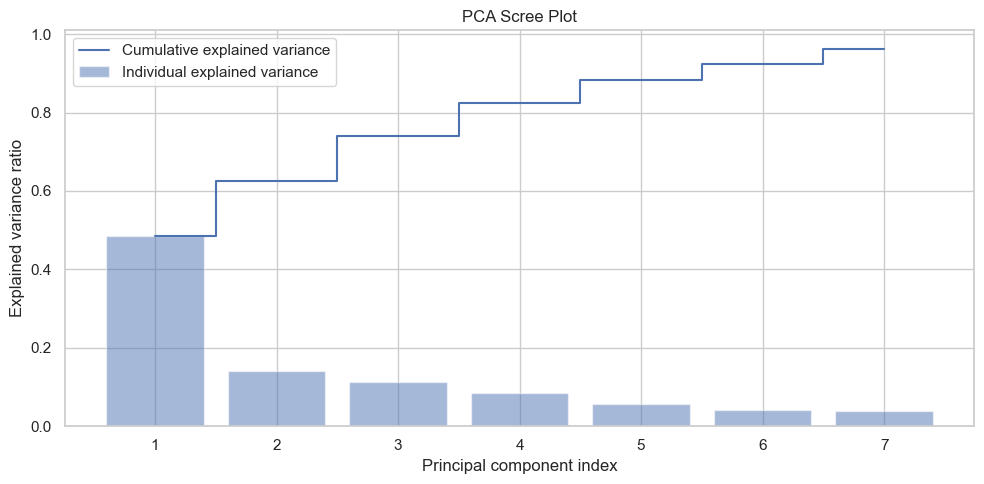

In [3]:
analyzer = UnsupervisedAnalyzer()
print("PCA on Environment (X):")
pca_x, _, _ = analyzer.run_pca(X)
analyzer.plot_pca_start(pca_x)

print("PCA on Morphology (Y):")
pca_y, _, _ = analyzer.run_pca(Y)
analyzer.plot_pca_start(pca_y)

## 3. Canonical Correlation Analysis (CCA)

CCA finds linear combinations of X and Y that are maximally correlated. This helps us understand if there's a strong shared structure between the two domains.

CCA Correlations (Top 2 components): [np.float64(0.6444294443099313), np.float64(0.40507657075377257)]


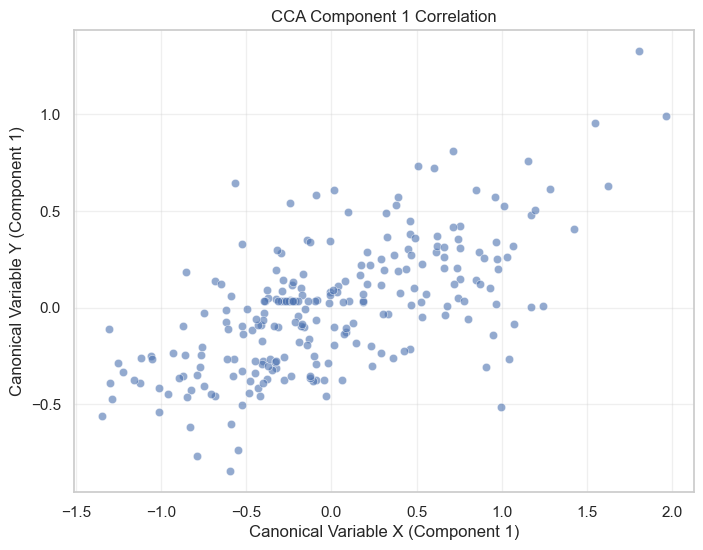

In [4]:
cca, X_c, Y_c = analyzer.run_cca(X, Y, n_components=2)
analyzer.plot_cca_results(X_c, Y_c, component_idx=0)

### Interpretation of CCA Loadings
Which features drive this correlation? The loadings show the correlation between the original features and the Canonical Variates.

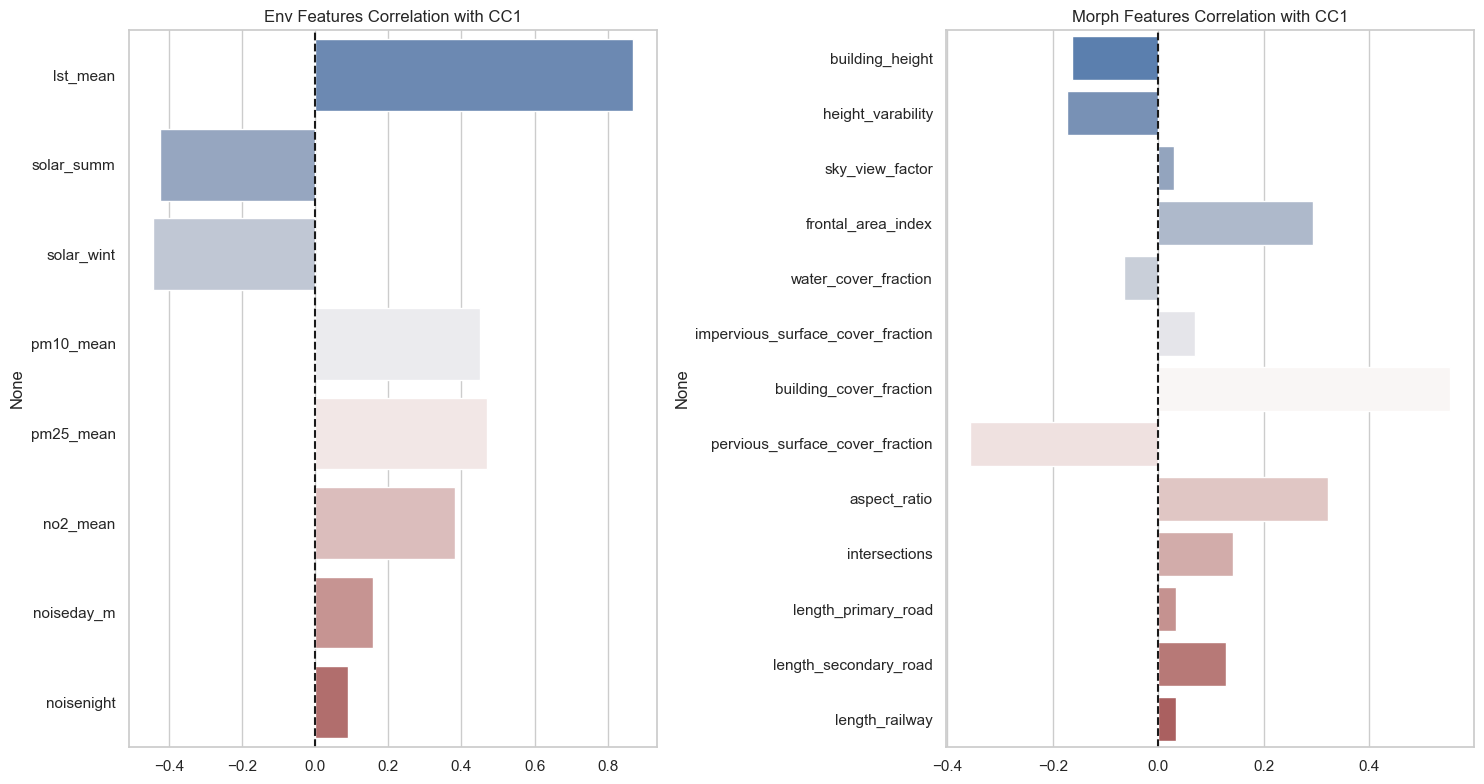

In [5]:
analyzer.plot_cca_loadings(X, Y, cca, component=0)

## 4. Clustering Analysis

Given the limited number of samples, **Hierarchical Clustering** is often more robust than density-based methods (like DBSCAN) as it doesn't rely on local density thresholds. We inspect the Dendrogram to determine the natural number of clusters.

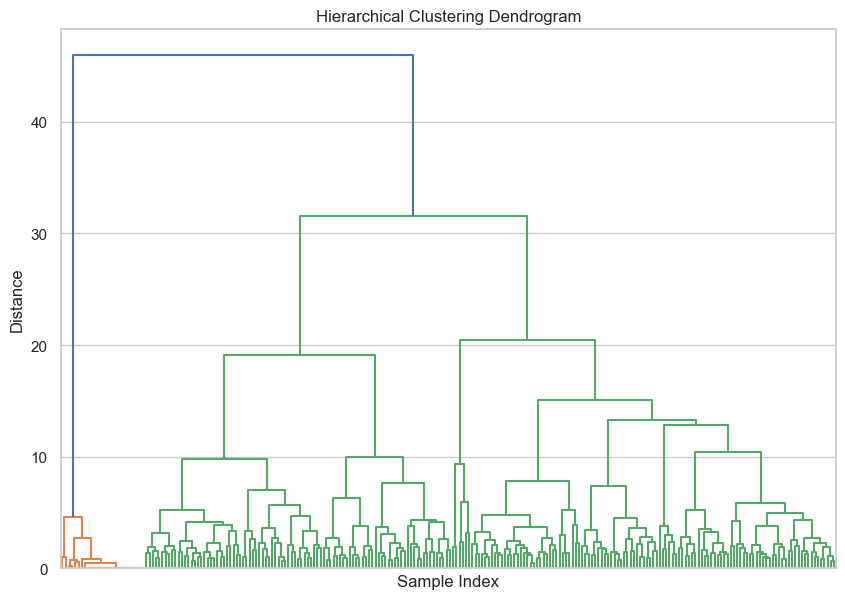

In [6]:
# 1. Hierarchical Clustering Dendrogram
analyzer.run_hierarchical_clustering(Y, method="ward")

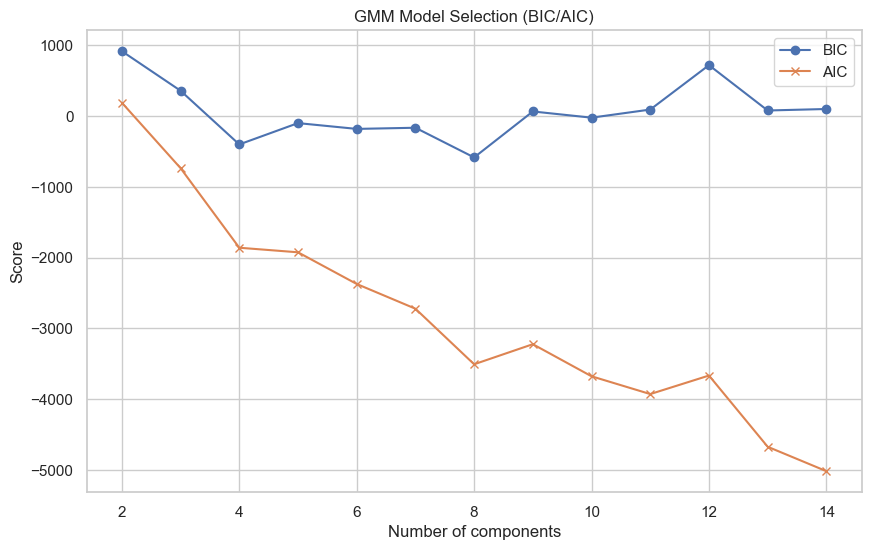

In [7]:
# 2. Model Selection Guidance (GMM BIC/AIC)
# This helps confirm if the number of clusters suggested by the dendrogram is statistically sound.
_ = analyzer.run_gmm(Y, n_components_range=range(2, 15))

In [8]:
# 3. Apply Agglomerative Clustering
# Based on Dendrogram and GMM, we choose a reasonable k (e.g., 3 or 4).
k_clusters = 8  # Adjust this based on the Dendrogram visual
print(f"Applying Agglomerative Clustering with k={k_clusters}...")

hc = AgglomerativeClustering(n_clusters=k_clusters)
labels_morph = hc.fit_predict(Y)

analyzer.evaluate_clustering(Y, labels_morph)

Applying Agglomerative Clustering with k=8...
Clustering Evaluation (n=8):
  Silhouette Score: 0.2542
  Calinski-Harabasz Score: 83.0290


{'silhouette': 0.2542001864946403, 'calinski': 83.02900971381177}

### Cluster Profiling
Values shown are Z-scores (deviations from the mean).

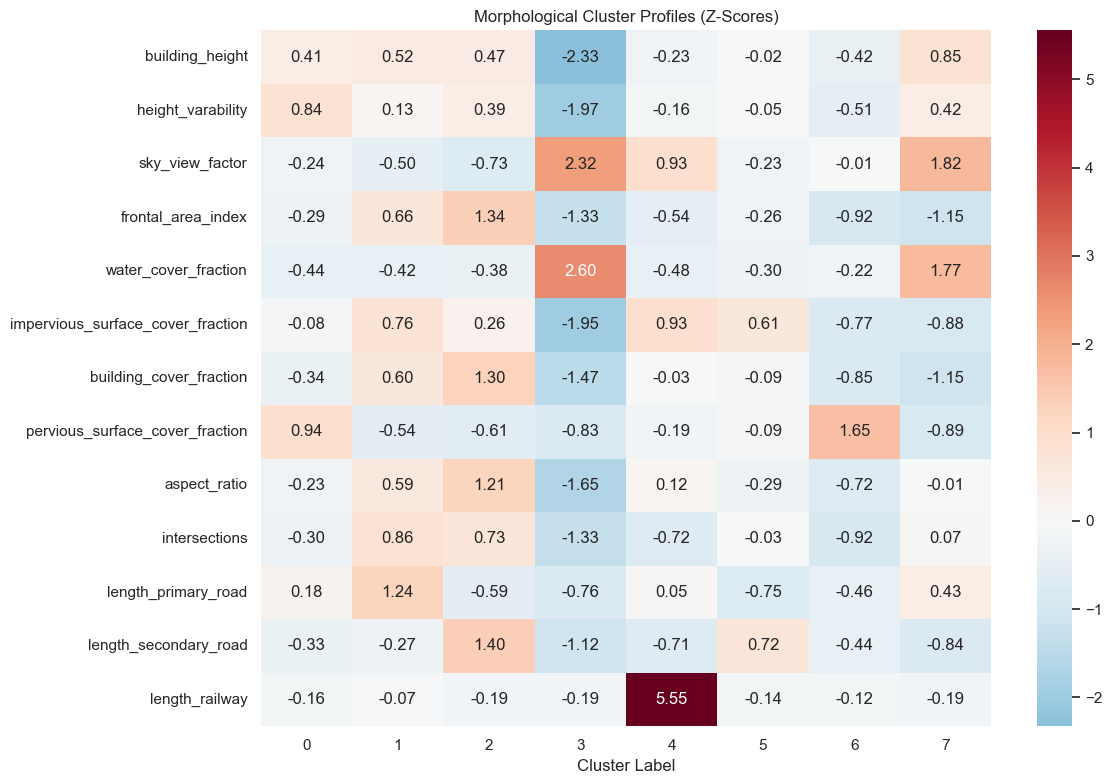

In [9]:
analyzer.plot_cluster_profile(
    Y, labels_morph, title="Morphological Cluster Profiles (Z-Scores)"
)

## 5. Manifold Learning
Visualizing the high-dimensional morphology space in 2D, colored by our new clusters.

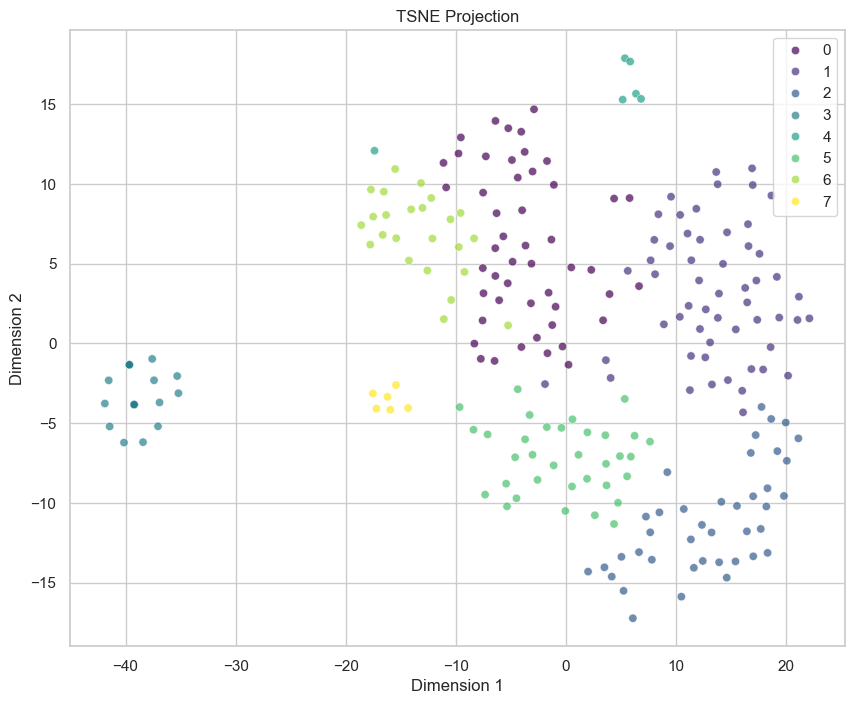

In [10]:
analyzer.run_manifold_learning(Y, color_by=labels_morph, method="tsne")

## 6. Surrogate Learning: Env -> Morph

**Objective**: Can environmental quality predict the morphological structure? 
We use **SHAP (SHapley Additive exPlanations)** to interpret the models.

--- I. Regression: Predicting Morphological Features directly ---
Surrogate Model (Ridge) Performance:
  Avg R2: -0.0728
  RMSE: 1.0444

[Regression SHAP] Understanding environmental drivers for morphology:
Running SHAP analysis on the first target dimension...


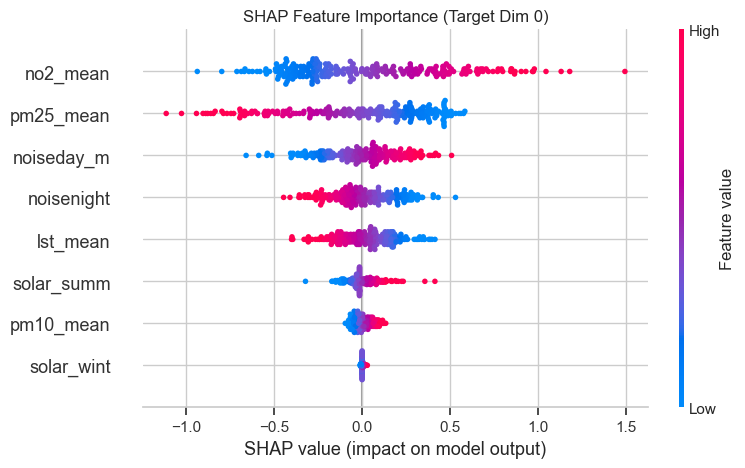

In [11]:
print("--- I. Regression: Predicting Morphological Features directly ---")
surrogate = SurrogateModel(model_type="ridge")
surrogate.train(X, Y)

# SHAP Analysis for Regression
print("\n[Regression SHAP] Understanding environmental drivers for morphology:")
surrogate.analyze_feature_importance(X)


Classification Report (Env -> Morph Cluster):
              precision    recall  f1-score   support

           0       0.40      0.59      0.48        49
           1       0.25      0.24      0.25        55
           2       0.26      0.33      0.29        40
           3       0.52      0.46      0.49        26
           4       0.00      0.00      0.00         6
           5       0.16      0.15      0.15        34
           6       0.08      0.04      0.06        24
           7       0.00      0.00      0.00         6

    accuracy                           0.30       240
   macro avg       0.21      0.23      0.21       240
weighted avg       0.27      0.30      0.28       240



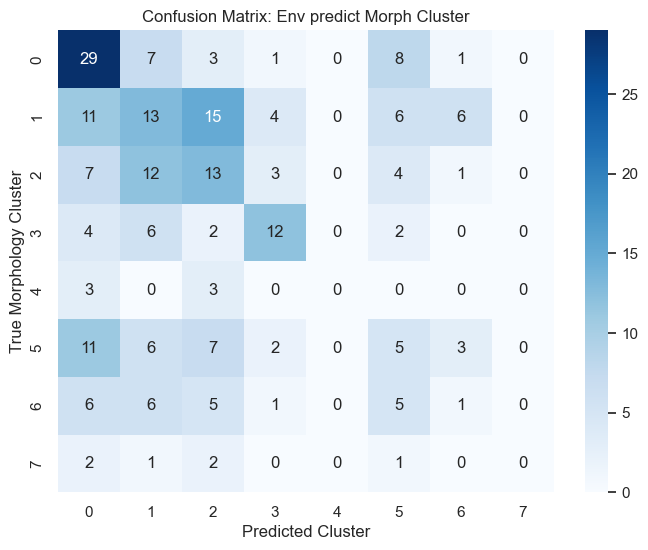

<Figure size 640x480 with 0 Axes>

Running SHAP analysis for Classification...


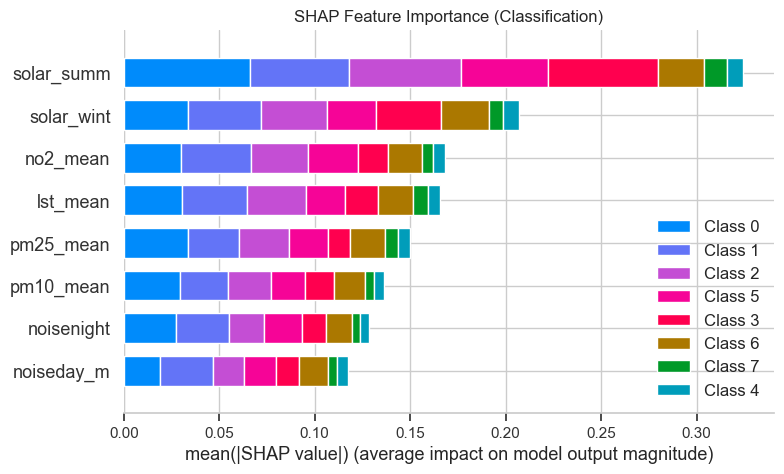

In [12]:
# Evaluate Classification (Env -> Morph Cluster)
# This includes SHAP analysis for the Classifier
surrogate.evaluate_classification(X, labels_morph)

## 7. Improved surrogate experiments

We keep the original surrogate intact and add two lightweight checks:
- Regress PCA-compressed morphology (lower noise, fewer targets) from environment using cross-validated Ridge and Random Forest.
- Classify morphology clusters directly from environment with stronger baselines and cross-validated weighted F1. 

In [13]:
# Regression: predict PCA-compressed morphology from environment (CV R2)
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor

# keeping 90% variance
pca = PCA(n_components=0.90, random_state=42)
Y_pca = pca.fit_transform(Y)
explained = pca.explained_variance_ratio_.sum()

# 5-fold cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# log space grid search for ridge regression hyperparameter
ridge = RidgeCV(alphas=np.logspace(-3, 3, 9), cv=cv)
# randomforest definition to enhance prexiction capabilities
rf = RandomForestRegressor(n_estimators=400, max_depth=None, random_state=42)

models = {
    "RidgeCV": ridge,
    "RandomForestRegressor": rf,
}

rows = []
for name, model in models.items():
    scores = cross_val_score(model, X, Y_pca, cv=cv, scoring="r2")
    rows.append({"model": name, "mean_R2": scores.mean(), "std_R2": scores.std()})

results_pca = pd.DataFrame(rows).sort_values("mean_R2", ascending=False)
print(f"PCA components retained: {Y_pca.shape[1]} (explained variance={explained:.3f})")
display(results_pca)

PCA components retained: 6 (explained variance=0.924)


,model,mean_R2,std_R2
1,RandomForestRegressor,0.020238,0.107071
0,RidgeCV,-0.020245,0.030982


In [14]:
# Classification: predict morphology clusters from environment (CV weighted F1)
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


mask = labels_morph != -1
X_cls = X[mask]
y_cls = labels_morph[mask]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_weighted = make_scorer(f1_score, average="weighted")

models_cls = {
    "LogReg (L2)": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=5000, class_weight="balanced", multi_class="auto"),
    ),
    "SVM (RBF)": make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", probability=True, class_weight="balanced", gamma="scale"),
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=None, class_weight="balanced", random_state=42
    ),
}

rows = []
for name, model in models_cls.items():
    scores = cross_val_score(model, X_cls, y_cls, cv=skf, scoring=f1_weighted)
    rows.append(
        {"model": name, "mean_F1_weighted": scores.mean(), "std_F1": scores.std()}
    )

results_cls = pd.DataFrame(rows).sort_values("mean_F1_weighted", ascending=False)
display(results_cls)

c:\Users\boiar\miniconda3\envs\notebook-run\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\boiar\miniconda3\envs\notebook-run\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\boiar\miniconda3\envs\notebook-run\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\boiar\miniconda3\envs\notebook-run\Lib\site-packages\sklearn\linear_mo

,model,mean_F1_weighted,std_F1
2,RandomForest,0.304621,0.039090
1,SVM (RBF),0.223542,0.019669
0,LogReg (L2),0.164987,0.042869


Best model: RandomForest | CV weighted F1: 0.308


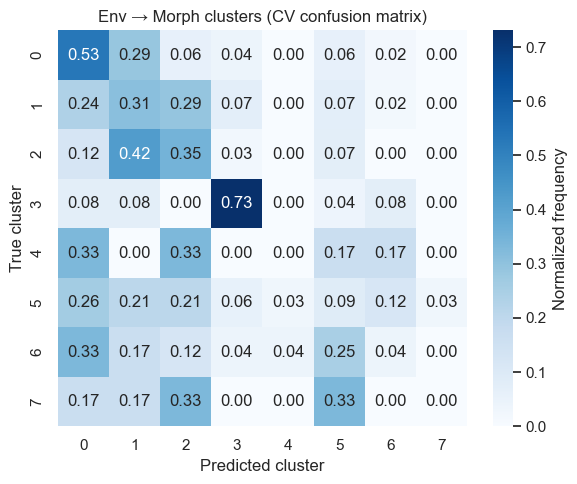

In [15]:
# Visualize morphology-cluster predictions (cross-validated confusion matrix)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score

# Picking the bets performing model we have
best_row = results_cls.iloc[0]
best_name = best_row["model"]
best_model = models_cls[best_name]

# intuitive cluster-level view
y_pred_cv = cross_val_predict(best_model, X_cls, y_cls, cv=skf)

cm = confusion_matrix(y_cls, y_pred_cv, labels=np.unique(y_cls))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

f1_cv = f1_score(y_cls, y_pred_cv, average="weighted")
print(f"Best model: {best_name} | CV weighted F1: {f1_cv:.3f}")

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    ax=ax,
    cbar_kws={"label": "Normalized frequency"},
)
ax.set_xlabel("Predicted cluster")
ax.set_ylabel("True cluster")
ax.set_title("Env → Morph clusters (CV confusion matrix)")
plt.tight_layout()
plt.show()

### 7.4 XGBoost with class-aware oversampling
Try an XGBoost classifier with SMOTE oversampling for rare clusters and a small grid on depth and learning rate. This is done because some clusters were hardly ever predicted

,n_estimators,max_depth,learning_rate,min_child_weight,mean_F1_weighted,std_F1
12,300,7,0.05,1,0.308730,0.061464
6,300,5,0.05,1,0.307357,0.062612
4,300,3,0.20,1,0.303434,0.062424
14,300,7,0.10,1,0.302330,0.072408
10,300,5,0.20,1,0.293948,0.043416
8,300,5,0.10,1,0.293659,0.062480
15,300,7,0.10,5,0.292661,0.057210
0,300,3,0.05,1,0.290728,0.036661
7,300,5,0.05,5,0.287293,0.064558
5,300,3,0.20,5,0.284125,0.043434


Best XGBoost params: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1} | CV weighted F1: 0.313


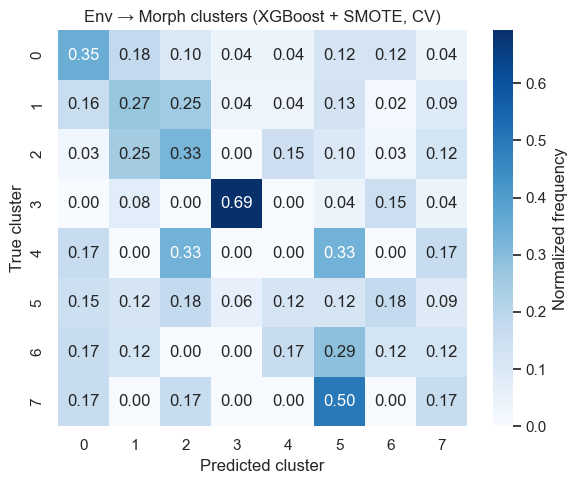

In [16]:
# 7.4 XGBoost with SMOTE oversampling for rare clusters
import numpy as np
import pandas as pd
from itertools import product
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Reuse the balanced subset (exclude noise if any)
mask = labels_morph != -1
X_xgb = X[mask]
y_xgb = labels_morph[mask]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Small, tractable grid for depth and learning rate
param_grid = {
    "n_estimators": [300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "min_child_weight": [1, 5],
}

rows = []
best_model = None
best_f1 = -np.inf

param_list = list(
    product(
        param_grid["n_estimators"],
        param_grid["max_depth"],
        param_grid["learning_rate"],
        param_grid["subsample"],
        param_grid["colsample_bytree"],
        param_grid["min_child_weight"],
    )
)

for n_est, depth, lr, subs, cols, mcw in param_list:
    clf = XGBClassifier(
        n_estimators=n_est,
        max_depth=depth,
        learning_rate=lr,
        subsample=subs,
        colsample_bytree=cols,
        min_child_weight=mcw,
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
    )

    pipeline = Pipeline(
        [("smote", SMOTE(k_neighbors=3, random_state=42)), ("clf", clf)]
    )
    scores = cross_val_score(pipeline, X_xgb, y_xgb, cv=skf, scoring="f1_weighted")

    mean_f1 = scores.mean()
    std_f1 = scores.std()
    rows.append(
        {
            "n_estimators": n_est,
            "max_depth": depth,
            "learning_rate": lr,
            "min_child_weight": mcw,
            "mean_F1_weighted": mean_f1,
            "std_F1": std_f1,
        }
    )

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_params = {
            "n_estimators": n_est,
            "max_depth": depth,
            "learning_rate": lr,
            "subsample": subs,
            "colsample_bytree": cols,
            "min_child_weight": mcw,
        }

# Display grid results
xgb_results = pd.DataFrame(rows).sort_values("mean_F1_weighted", ascending=False)
display(xgb_results)

# Fit best model with SMOTE on full data and show CV confusion matrix
best_clf = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
)
best_pipe = Pipeline(
    [("smote", SMOTE(k_neighbors=3, random_state=42)), ("clf", best_clf)]
)

# Cross-validated predictions for visualization
cv_preds = cross_val_predict(best_pipe, X_xgb, y_xgb, cv=skf)
cv_f1 = f1_score(y_xgb, cv_preds, average="weighted")

cm = confusion_matrix(y_xgb, cv_preds, labels=np.unique(y_xgb))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

print(f"Best XGBoost params: {best_params} | CV weighted F1: {cv_f1:.3f}")

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    ax=ax,
    cbar_kws={"label": "Normalized frequency"},
)
ax.set_xlabel("Predicted cluster")
ax.set_ylabel("True cluster")
ax.set_title("Env → Morph clusters (XGBoost + SMOTE, CV)")
plt.tight_layout()
plt.show()

### 7.5 Diagnostics: per-class scores and feature importances
Summarize per-cluster precision/recall/F1 from cross-val predictions and inspect the top environmental drivers learned by XGBoost (fitted on SMOTE-balanced data).

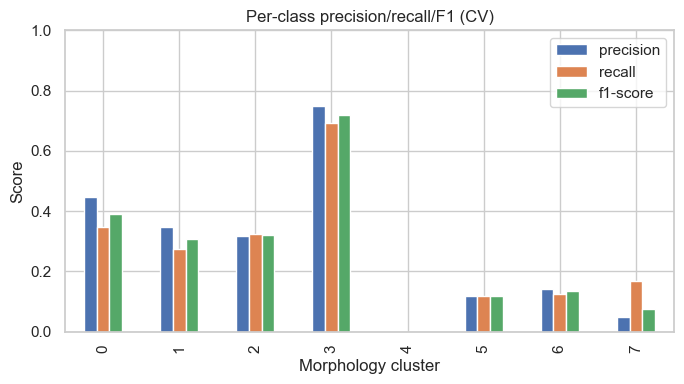

C:\Users\boiar\AppData\Local\Temp\ipykernel_37924\161929811.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, y="feature", x="importance", ax=ax, palette="Blues_r")


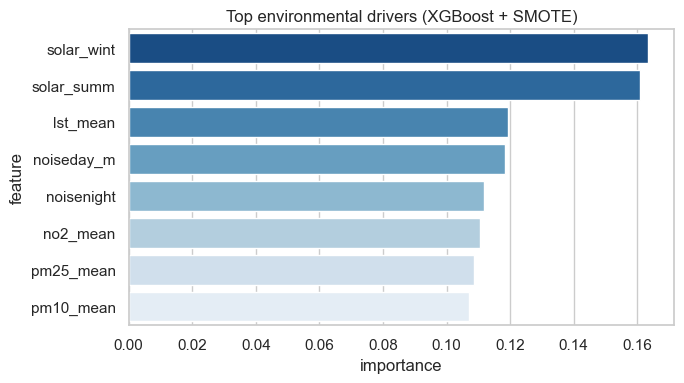

In [17]:
# Per-class metrics and feature importances
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Per-class metrics from existing CV predictions (cv_preds, y_xgb) created above
report = classification_report(y_xgb, cv_preds, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T


class_rows = report_df.loc[
    [c for c in report_df.index if c not in ["accuracy", "macro avg", "weighted avg"]]
].copy()
class_rows = class_rows[["precision", "recall", "f1-score"]]

fig, ax = plt.subplots(figsize=(7, 4))
class_rows.plot(kind="bar", ax=ax)
ax.set_title("Per-class precision/recall/F1 (CV)")
ax.set_xlabel("Morphology cluster")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# Fit best XGB on SMOTE-balanced data to inspect feature importances
smote = SMOTE(k_neighbors=3, random_state=42)
X_bal, y_bal = smote.fit_resample(X_xgb, y_xgb)

best_clf_fit = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
)
best_clf_fit.fit(X_bal, y_bal)

importances = best_clf_fit.feature_importances_
fi_df = pd.DataFrame({"feature": X_xgb.columns, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False).head(12)

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(data=fi_df, y="feature", x="importance", ax=ax, palette="Blues_r")
ax.set_title("Top environmental drivers (XGBoost + SMOTE)")
plt.tight_layout()
plt.show()

## 8. Environmental Quality Clustering with GMM

We now cluster the environmental features (X) directly using Gaussian Mixture Models to identify distinct environmental quality typologies. Then we explore whether these EQ-based clusters can predict neighbourhood typology.

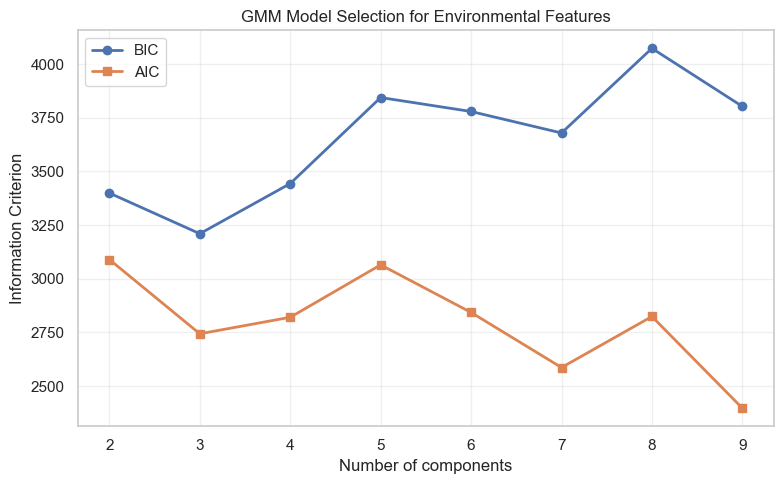

Optimal number of components (BIC): 3
Optimal number of components (AIC): 9


In [18]:
# 8.1 GMM Model Selection for Environmental Features
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Test different numbers of components
n_components_range = range(2, 10)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, covariance_type="full")
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

# Plot model selection criteria
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(n_components_range, bic_scores, "o-", label="BIC", linewidth=2)
ax.plot(n_components_range, aic_scores, "s-", label="AIC", linewidth=2)
ax.set_xlabel("Number of components")
ax.set_ylabel("Information Criterion")
ax.set_title("GMM Model Selection for Environmental Features")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select optimal number based on lowest BIC
optimal_n = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components (BIC): {optimal_n}")
print(
    f"Optimal number of components (AIC): {n_components_range[np.argmin(aic_scores)]}"
)

In [19]:
# 8.2 Fit GMM with optimal components and extract cluster labels
k_eq = optimal_n  # Use the optimal number from BIC
print(f"Fitting GMM with {k_eq} components on Environmental Features...")

gmm_eq = GaussianMixture(n_components=k_eq, random_state=42, covariance_type="full")
labels_eq = gmm_eq.fit_predict(X)

# Evaluate clustering quality
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

sil_score = silhouette_score(X, labels_eq)
db_score = davies_bouldin_score(X, labels_eq)
ch_score = calinski_harabasz_score(X, labels_eq)

print(f"\nClustering Quality Metrics:")
print(f"  Silhouette Score: {sil_score:.3f} (higher is better, range [-1, 1])")
print(f"  Davies-Bouldin Index: {db_score:.3f} (lower is better)")
print(f"  Calinski-Harabasz Index: {ch_score:.1f} (higher is better)")
print(f"\nCluster sizes: {np.bincount(labels_eq)}")

Fitting GMM with 3 components on Environmental Features...

Clustering Quality Metrics:
  Silhouette Score: 0.098 (higher is better, range [-1, 1])
  Davies-Bouldin Index: 2.530 (lower is better)
  Calinski-Harabasz Index: 62.3 (higher is better)

Cluster sizes: [ 48  86 106]


### 8.3 Environmental Cluster Profiling
Characterize each EQ cluster by its mean environmental feature values (in Z-scores).

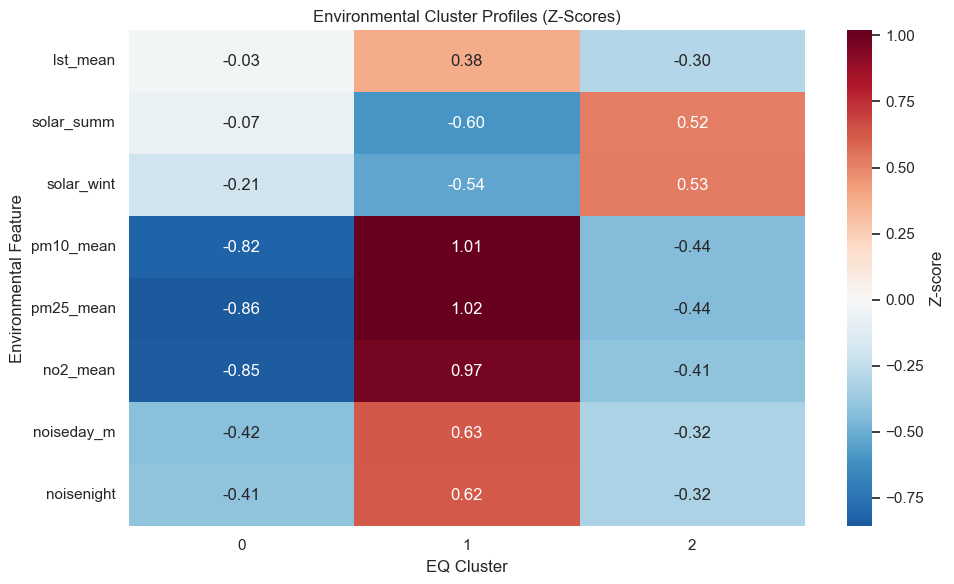


Cluster Distribution:
EQ_Cluster
0     48
1     86
2    106
Name: count, dtype: int64


In [20]:
# Profile EQ clusters by their mean feature values
X_with_labels = X.copy()
X_with_labels["EQ_Cluster"] = labels_eq

# Compute mean Z-scores for each cluster
cluster_profiles = X_with_labels.groupby("EQ_Cluster").mean()

# Visualize cluster profiles as heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    cluster_profiles.T,
    cmap="RdBu_r",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Z-score"},
    ax=ax,
)
ax.set_xlabel("EQ Cluster")
ax.set_ylabel("Environmental Feature")
ax.set_title("Environmental Cluster Profiles (Z-Scores)")
plt.tight_layout()
plt.show()

# Display cluster sizes
print("\nCluster Distribution:")
print(X_with_labels["EQ_Cluster"].value_counts().sort_index())

## 9. Advanced Analysis: Cross-Domain Predictions and Relationships

Now that we have both morphological and environmental clusters, we can explore their relationships in depth.

### 9.1 Reverse Prediction: Morphology → Environmental Clusters

**Research Question**: Can urban morphology predict environmental quality typology?

This is the inverse of the earlier surrogate analysis. We test if physical form determines environmental outcomes using the same robust methods (cross-validation + SMOTE for class balance).

c:\Users\boiar\miniconda3\envs\notebook-run\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\boiar\miniconda3\envs\notebook-run\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\boiar\miniconda3\envs\notebook-run\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\boiar\miniconda3\envs\notebook-run\Lib\site-packages\sklearn\linear_mo

=== Morphology → Environmental Cluster Classification ===


,model,mean_F1_weighted,std_F1
2,RandomForest,0.513774,0.024984
3,XGBoost + SMOTE,0.499205,0.074756
1,SVM (RBF),0.498443,0.033643
0,LogReg (L2),0.477923,0.037369



Best model: RandomForest | CV weighted F1: 0.514


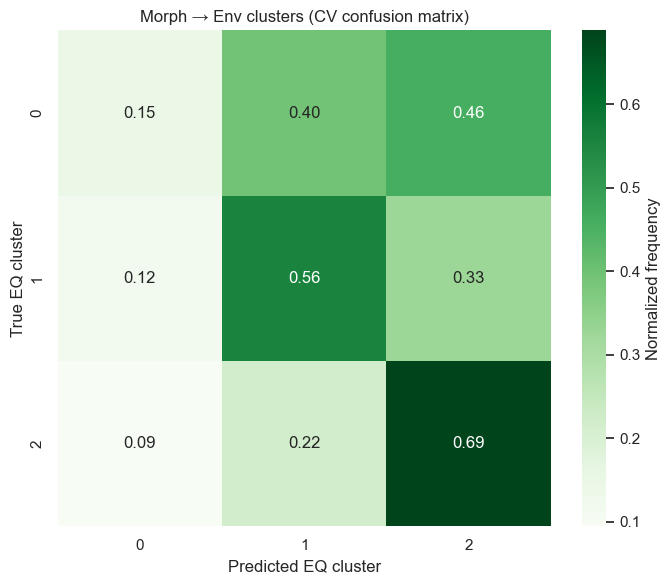

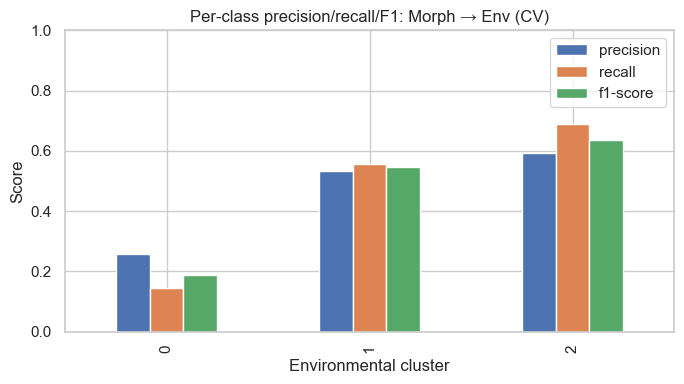

In [21]:
# Reverse surrogate: Morph → Env clusters (multi-class classification)
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Setup: Y (morphology) predicts labels_eq (environmental clusters)
Y_rev = Y.copy()
y_rev = labels_eq.copy()

skf_rev = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_weighted_rev = make_scorer(f1_score, average="weighted")

# Test multiple models with class balancing
models_rev = {
    "LogReg (L2)": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=5000, class_weight="balanced", multi_class="auto", random_state=42)
    ),
    "SVM (RBF)": make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", probability=True, class_weight="balanced", gamma="scale", random_state=42)
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=None, class_weight="balanced", random_state=42
    ),
    "XGBoost + SMOTE": Pipeline([
        ("smote", SMOTE(k_neighbors=3, random_state=42)),
        ("clf", XGBClassifier(
            n_estimators=300, max_depth=5, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            objective="multi:softprob", eval_metric="mlogloss",
            random_state=42, n_jobs=-1
        ))
    ])
}

rows_rev = []
for name, model in models_rev.items():
    scores = cross_val_score(model, Y_rev, y_rev, cv=skf_rev, scoring=f1_weighted_rev)
    rows_rev.append({
        "model": name,
        "mean_F1_weighted": scores.mean(),
        "std_F1": scores.std()
    })

results_rev = pd.DataFrame(rows_rev).sort_values("mean_F1_weighted", ascending=False)
print("=== Morphology → Environmental Cluster Classification ===")
display(results_rev)

# Visualize best model's confusion matrix
best_row_rev = results_rev.iloc[0]
best_name_rev = best_row_rev["model"]
best_model_rev = models_rev[best_name_rev]

y_pred_rev = cross_val_predict(best_model_rev, Y_rev, y_rev, cv=skf_rev)
cm_rev = confusion_matrix(y_rev, y_pred_rev, labels=np.unique(y_rev))
cm_rev_norm = cm_rev / cm_rev.sum(axis=1, keepdims=True)

f1_rev = f1_score(y_rev, y_pred_rev, average="weighted")
print(f"\nBest model: {best_name_rev} | CV weighted F1: {f1_rev:.3f}")

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(
    cm_rev_norm, annot=True, fmt=".2f", cmap="Greens", ax=ax,
    cbar_kws={"label": "Normalized frequency"}
)
ax.set_xlabel("Predicted EQ cluster")
ax.set_ylabel("True EQ cluster")
ax.set_title("Morph → Env clusters (CV confusion matrix)")
plt.tight_layout()
plt.show()

# Per-class performance
report_rev = classification_report(y_rev, y_pred_rev, output_dict=True, zero_division=0)
report_rev_df = pd.DataFrame(report_rev).T
class_rows_rev = report_rev_df.loc[
    [c for c in report_rev_df.index if c not in ["accuracy", "macro avg", "weighted avg"]]
].copy()
class_rows_rev = class_rows_rev[["precision", "recall", "f1-score"]]

fig, ax = plt.subplots(figsize=(7, 4))
class_rows_rev.plot(kind="bar", ax=ax)
ax.set_title("Per-class precision/recall/F1: Morph → Env (CV)")
ax.set_xlabel("Environmental cluster")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

### 9.2 Cross-Tabulation: Morphology vs Environmental Clusters

**Objective**: Understand the alignment (or misalignment) between morphological typologies and environmental quality zones.

High alignment suggests form and environment are tightly coupled. Low alignment suggests other factors (policy, location, etc.) decouple them.

=== Contingency Table: Morphology × Environment ===


Environmental Cluster,0,1,2,All
Morphology Cluster,,,,
0,9,6,34,49
1,15,22,18,55
2,8,25,7,40
3,7,9,10,26
4,0,1,5,6
5,4,13,17,34
6,3,7,14,24
7,2,3,1,6
All,48,86,106,240



Chi-square test for independence:
  χ² = 42.61, p-value = 0.0001, dof = 14
  → Clusters are statistically dependent (p < 0.05)

Cluster Agreement Metrics:
  Adjusted Rand Index (ARI): 0.039 (1=perfect, 0=random)
  Normalized Mutual Info (NMI): 0.065 (1=perfect, 0=independent)


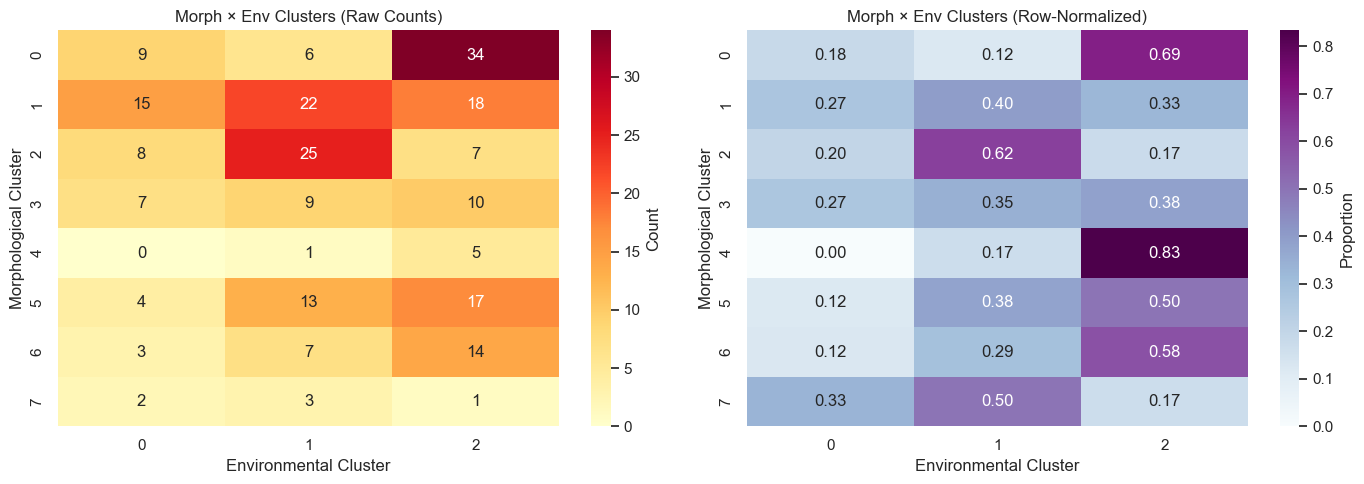

In [22]:
# Cross-tabulation and association metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Create contingency table
crosstab = pd.crosstab(
    labels_morph, labels_eq,
    rownames=["Morphology Cluster"],
    colnames=["Environmental Cluster"],
    margins=True
)

print("=== Contingency Table: Morphology × Environment ===")
display(crosstab)

# Statistical independence test (Chi-square)
chi2, p_value, dof, expected = chi2_contingency(crosstab.iloc[:-1, :-1])
print(f"\nChi-square test for independence:")
print(f"  χ² = {chi2:.2f}, p-value = {p_value:.4f}, dof = {dof}")
if p_value < 0.05:
    print("  → Clusters are statistically dependent (p < 0.05)")
else:
    print("  → No significant association detected")

# Clustering agreement metrics
ari = adjusted_rand_score(labels_morph, labels_eq)
nmi = normalized_mutual_info_score(labels_morph, labels_eq)

print(f"\nCluster Agreement Metrics:")
print(f"  Adjusted Rand Index (ARI): {ari:.3f} (1=perfect, 0=random)")
print(f"  Normalized Mutual Info (NMI): {nmi:.3f} (1=perfect, 0=independent)")

# Visualize contingency table as heatmap (normalized by row)
crosstab_norm = crosstab.iloc[:-1, :-1].div(crosstab.iloc[:-1, -1], axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(
    crosstab.iloc[:-1, :-1], annot=True, fmt="d", cmap="YlOrRd",
    ax=axes[0], cbar_kws={"label": "Count"}
)
axes[0].set_title("Morph × Env Clusters (Raw Counts)")
axes[0].set_xlabel("Environmental Cluster")
axes[0].set_ylabel("Morphological Cluster")

# Normalized by row (conditional distribution)
sns.heatmap(
    crosstab_norm, annot=True, fmt=".2f", cmap="BuPu",
    ax=axes[1], cbar_kws={"label": "Proportion"}
)
axes[1].set_title("Morph × Env Clusters (Row-Normalized)")
axes[1].set_xlabel("Environmental Cluster")
axes[1].set_ylabel("Morphological Cluster")

plt.tight_layout()
plt.show()

### 9.3 Cluster Stability Analysis (Bootstrap Validation)

**Critical for small datasets**: Test whether clusters are robust or sample-dependent.

Method: Resample with replacement 100 times, re-cluster each bootstrap sample, measure agreement with original clustering using Adjusted Rand Index (ARI).


=== Morphology Cluster Stability (n=100 bootstraps) ===
  Mean ARI: 0.585
  Std ARI: 0.094
  Median ARI: 0.591
  Range: [0.358, 0.830]

Stability assessment: MODERATE - some instability detected


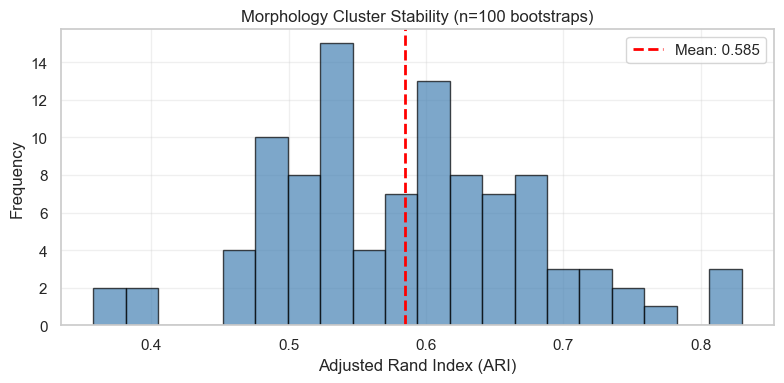

In [24]:
# Bootstrap stability analysis for morphology clusters
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

n_bootstrap = 100
ari_scores_morph = []



for i in range(n_bootstrap):
    # Resample with replacement
    indices = resample(np.arange(len(Y)), replace=True, random_state=i)
    Y_boot = Y.iloc[indices]
    
    # Re-cluster
    hc_boot = AgglomerativeClustering(n_clusters=k_clusters)
    labels_boot = hc_boot.fit_predict(Y_boot)
    
    # Compare to original labels (for resampled indices)
    ari = adjusted_rand_score(labels_morph[indices], labels_boot)
    ari_scores_morph.append(ari)

ari_scores_morph = np.array(ari_scores_morph)

print(f"\n=== Morphology Cluster Stability (n={n_bootstrap} bootstraps) ===")
print(f"  Mean ARI: {ari_scores_morph.mean():.3f}")
print(f"  Std ARI: {ari_scores_morph.std():.3f}")
print(f"  Median ARI: {np.median(ari_scores_morph):.3f}")
print(f"  Range: [{ari_scores_morph.min():.3f}, {ari_scores_morph.max():.3f}]")

# Interpretation guide
if ari_scores_morph.mean() > 0.8:
    stability = "EXCELLENT - clusters are very stable"
elif ari_scores_morph.mean() > 0.6:
    stability = "GOOD - clusters are moderately stable"
elif ari_scores_morph.mean() > 0.4:
    stability = "MODERATE - some instability detected"
else:
    stability = "POOR - clusters are unstable (consider fewer clusters)"

print(f"\nStability assessment: {stability}")

# Visualize distribution
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(ari_scores_morph, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(ari_scores_morph.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ari_scores_morph.mean():.3f}')
ax.set_xlabel("Adjusted Rand Index (ARI)")
ax.set_ylabel("Frequency")
ax.set_title(f"Morphology Cluster Stability (n={n_bootstrap} bootstraps)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Running bootstrap validation for environmental clusters...

=== Environmental Cluster Stability (n=100 bootstraps) ===
  Mean ARI: 0.354
  Std ARI: 0.118
  Median ARI: 0.336
  Range: [0.179, 0.799]

Stability assessment: POOR - clusters are unstable


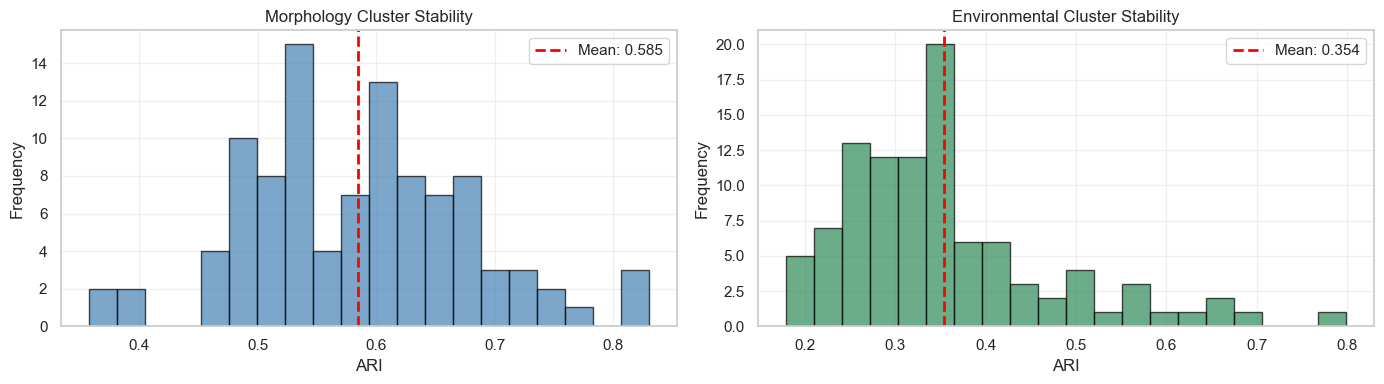

In [25]:
# Bootstrap stability for environmental clusters (GMM)
from sklearn.mixture import GaussianMixture

ari_scores_env = []

print("Running bootstrap validation for environmental clusters...")

for i in range(n_bootstrap):
    indices = resample(np.arange(len(X)), replace=True, random_state=i)
    X_boot = X.iloc[indices]
    
    # Re-cluster with GMM
    gmm_boot = GaussianMixture(n_components=k_eq, random_state=42, covariance_type="full")
    labels_boot = gmm_boot.fit_predict(X_boot)
    
    # Compare to original
    ari = adjusted_rand_score(labels_eq[indices], labels_boot)
    ari_scores_env.append(ari)

ari_scores_env = np.array(ari_scores_env)

print(f"\n=== Environmental Cluster Stability (n={n_bootstrap} bootstraps) ===")
print(f"  Mean ARI: {ari_scores_env.mean():.3f}")
print(f"  Std ARI: {ari_scores_env.std():.3f}")
print(f"  Median ARI: {np.median(ari_scores_env):.3f}")
print(f"  Range: [{ari_scores_env.min():.3f}, {ari_scores_env.max():.3f}]")

if ari_scores_env.mean() > 0.8:
    stability_env = "EXCELLENT - clusters are very stable"
elif ari_scores_env.mean() > 0.6:
    stability_env = "GOOD - clusters are moderately stable"
elif ari_scores_env.mean() > 0.4:
    stability_env = "MODERATE - some instability detected"
else:
    stability_env = "POOR - clusters are unstable"

print(f"\nStability assessment: {stability_env}")

# Compare both domains
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(ari_scores_morph, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(ari_scores_morph.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ari_scores_morph.mean():.3f}')
axes[0].set_xlabel("ARI")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Morphology Cluster Stability")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(ari_scores_env, bins=20, color='seagreen', alpha=0.7, edgecolor='black')
axes[1].axvline(ari_scores_env.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ari_scores_env.mean():.3f}')
axes[1].set_xlabel("ARI")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Environmental Cluster Stability")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 9.4 Statistical Feature Characterization

Beyond mean Z-scores, we test which features **significantly** differentiate clusters using ANOVA/Kruskal-Wallis tests.

=== Morphological Features: Significance Across Morph Clusters ===
Using Kruskal-Wallis test (non-parametric, suitable for small samples)

13/13 features are significant (p < 0.05)


,feature,statistic,p_value,effect_size,significant
3,frontal_area_index,183.837026,3.013499e-36,2.848070,True
6,building_cover_fraction,179.720754,2.231481e-35,2.641407,True
8,aspect_ratio,165.763448,1.961702e-32,2.285848,True
7,pervious_surface_cover_fraction,156.338346,1.890183e-30,2.102540,True
9,intersections,151.839960,1.667368e-29,1.305846,True
11,length_secondary_road,146.113198,2.657079e-28,1.654385,True
5,impervious_surface_cover_fraction,144.643768,5.403370e-28,2.487812,True
10,length_primary_road,142.844980,1.287864e-27,1.404614,True
4,water_cover_fraction,134.376471,7.645282e-26,15.003998,True
2,sky_view_factor,133.607168,1.107403e-25,5.823948,True



=== Environmental Features: Significance Across Env Clusters ===
Using Kruskal-Wallis test

8/8 features are significant (p < 0.05)


,feature,statistic,p_value,effect_size,significant
4,pm25_mean,137.837623,1.172035e-30,1.523035,True
3,pm10_mean,130.527704,4.531784e-29,1.418015,True
5,no2_mean,130.297802,5.083840e-29,1.249067,True
1,solar_summ,68.225950,1.530817e-15,0.327823,True
2,solar_wint,58.003108,2.539716e-13,0.310727,True
6,noiseday_m,53.434025,2.494301e-12,0.284099,True
7,noisenight,53.013146,3.078517e-12,0.275225,True
0,lst_mean,25.557228,2.820451e-06,0.099243,True


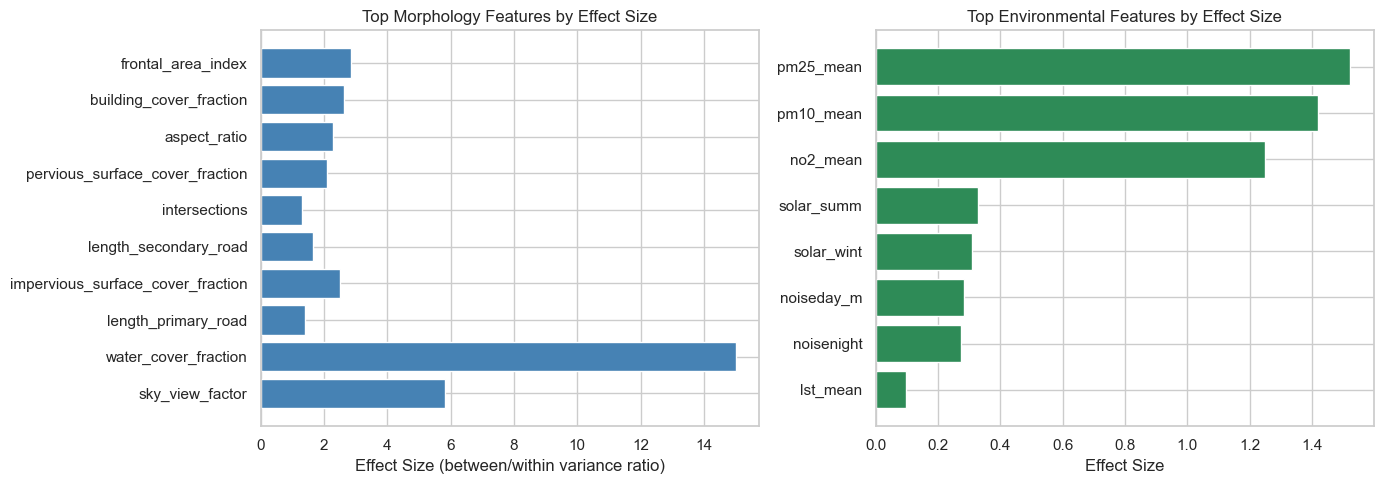

In [26]:
# Statistical tests for feature significance across clusters
from scipy.stats import kruskal, f_oneway
import pandas as pd

def test_features_significance(data, labels, test_type="kruskal"):
    """Test which features significantly differ across clusters."""
    results = []
    
    for col in data.columns:
        # Group data by cluster
        groups = [data[col][labels == i].values for i in np.unique(labels)]
        
        # Perform statistical test
        if test_type == "kruskal":
            stat, p_value = kruskal(*groups)
            test_name = "Kruskal-Wallis"
        else:
            stat, p_value = f_oneway(*groups)
            test_name = "ANOVA"
        
        # Effect size: ratio of between-group to within-group variance
        overall_mean = data[col].mean()
        between_var = sum([len(g) * (g.mean() - overall_mean)**2 for g in groups]) / len(data)
        within_var = sum([np.var(g) * len(g) for g in groups]) / len(data)
        effect_size = between_var / (within_var + 1e-10)  # Avoid division by zero
        
        results.append({
            "feature": col,
            "statistic": stat,
            "p_value": p_value,
            "effect_size": effect_size,
            "significant": p_value < 0.05
        })
    
    df = pd.DataFrame(results).sort_values("p_value")
    return df, test_name

# Test morphological features across morphology clusters
print("=== Morphological Features: Significance Across Morph Clusters ===")
morph_sig, test_name_m = test_features_significance(Y, labels_morph, test_type="kruskal")
print(f"Using {test_name_m} test (non-parametric, suitable for small samples)")
print(f"\n{morph_sig['significant'].sum()}/{len(morph_sig)} features are significant (p < 0.05)")
display(morph_sig.head(15))

# Test environmental features across environmental clusters
print("\n=== Environmental Features: Significance Across Env Clusters ===")
env_sig, test_name_e = test_features_significance(X, labels_eq, test_type="kruskal")
print(f"Using {test_name_e} test")
print(f"\n{env_sig['significant'].sum()}/{len(env_sig)} features are significant (p < 0.05)")
display(env_sig.head(15))

# Visualize effect sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

top_morph = morph_sig.nsmallest(10, "p_value")
axes[0].barh(top_morph["feature"], top_morph["effect_size"], color='steelblue')
axes[0].set_xlabel("Effect Size (between/within variance ratio)")
axes[0].set_title("Top Morphology Features by Effect Size")
axes[0].invert_yaxis()

top_env = env_sig.nsmallest(10, "p_value")
axes[1].barh(top_env["feature"], top_env["effect_size"], color='seagreen')
axes[1].set_xlabel("Effect Size")
axes[1].set_title("Top Environmental Features by Effect Size")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 9.5 Bidirectional Prediction Summary

Compare predictability in both directions to understand the asymmetry in environment-morphology relationships.

=== Bidirectional Prediction Performance ===


,Direction,Best Model,CV F1 (weighted),Task
0,Env → Morph clusters,RandomForest,0.308197,Classification
1,Morph → Env clusters,RandomForest,0.514374,Classification



Interpretation: Morph → Env is EASIER - form strongly determines environmental outcomes
F1 difference: 0.206


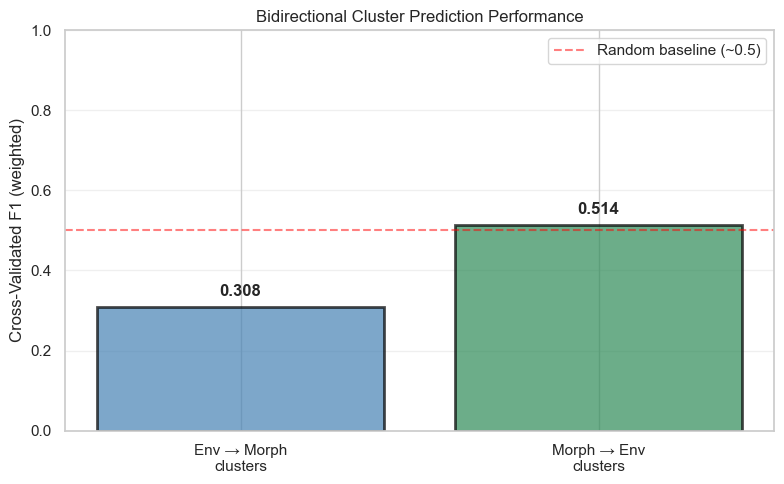

In [27]:
# Bidirectional prediction comparison
import pandas as pd
import matplotlib.pyplot as plt

# Gather all prediction results
prediction_summary = pd.DataFrame([
    {
        "Direction": "Env → Morph clusters",
        "Best Model": best_name,
        "CV F1 (weighted)": f1_cv,
        "Task": "Classification"
    },
    {
        "Direction": "Morph → Env clusters",
        "Best Model": best_name_rev,
        "CV F1 (weighted)": f1_rev,
        "Task": "Classification"
    }
])

print("=== Bidirectional Prediction Performance ===")
display(prediction_summary)

# Interpret asymmetry
diff = abs(f1_cv - f1_rev)
if diff < 0.05:
    interpretation = "Nearly symmetric - both directions predict equally well"
elif f1_cv > f1_rev:
    interpretation = "Env → Morph is EASIER - environment strongly determines form"
else:
    interpretation = "Morph → Env is EASIER - form strongly determines environmental outcomes"

print(f"\nInterpretation: {interpretation}")
print(f"F1 difference: {diff:.3f}")

# Visual comparison
fig, ax = plt.subplots(figsize=(8, 5))
directions = ["Env → Morph\nclusters", "Morph → Env\nclusters"]
scores = [f1_cv, f1_rev]
colors = ['steelblue', 'seagreen']

bars = ax.bar(directions, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel("Cross-Validated F1 (weighted)")
ax.set_title("Bidirectional Cluster Prediction Performance")
ax.set_ylim(0, 1)
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Random baseline (~0.5)')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.legend()
plt.tight_layout()
plt.show()

## 11. Environmental Quality Distribution by Typology

**Objective**: Analyze how EQ clusters are distributed across the original typology feature from the morphology dataset. This reveals whether specific urban typologies systematically experience certain environmental quality patterns.

=== Environmental Quality Distribution by Typology ===


EQ Cluster,0,1,2,All
typology,,,,
A,16,20,22,58
B,8,10,8,26
C,4,10,11,25
D,3,6,11,20
E,8,12,22,42
F,0,1,4,5
G,2,11,12,25
I,0,6,6,12
J,7,10,10,27



Chi-square test for independence:
  χ² = 16.51, p-value = 0.4182, dof = 16
  → No significant association detected


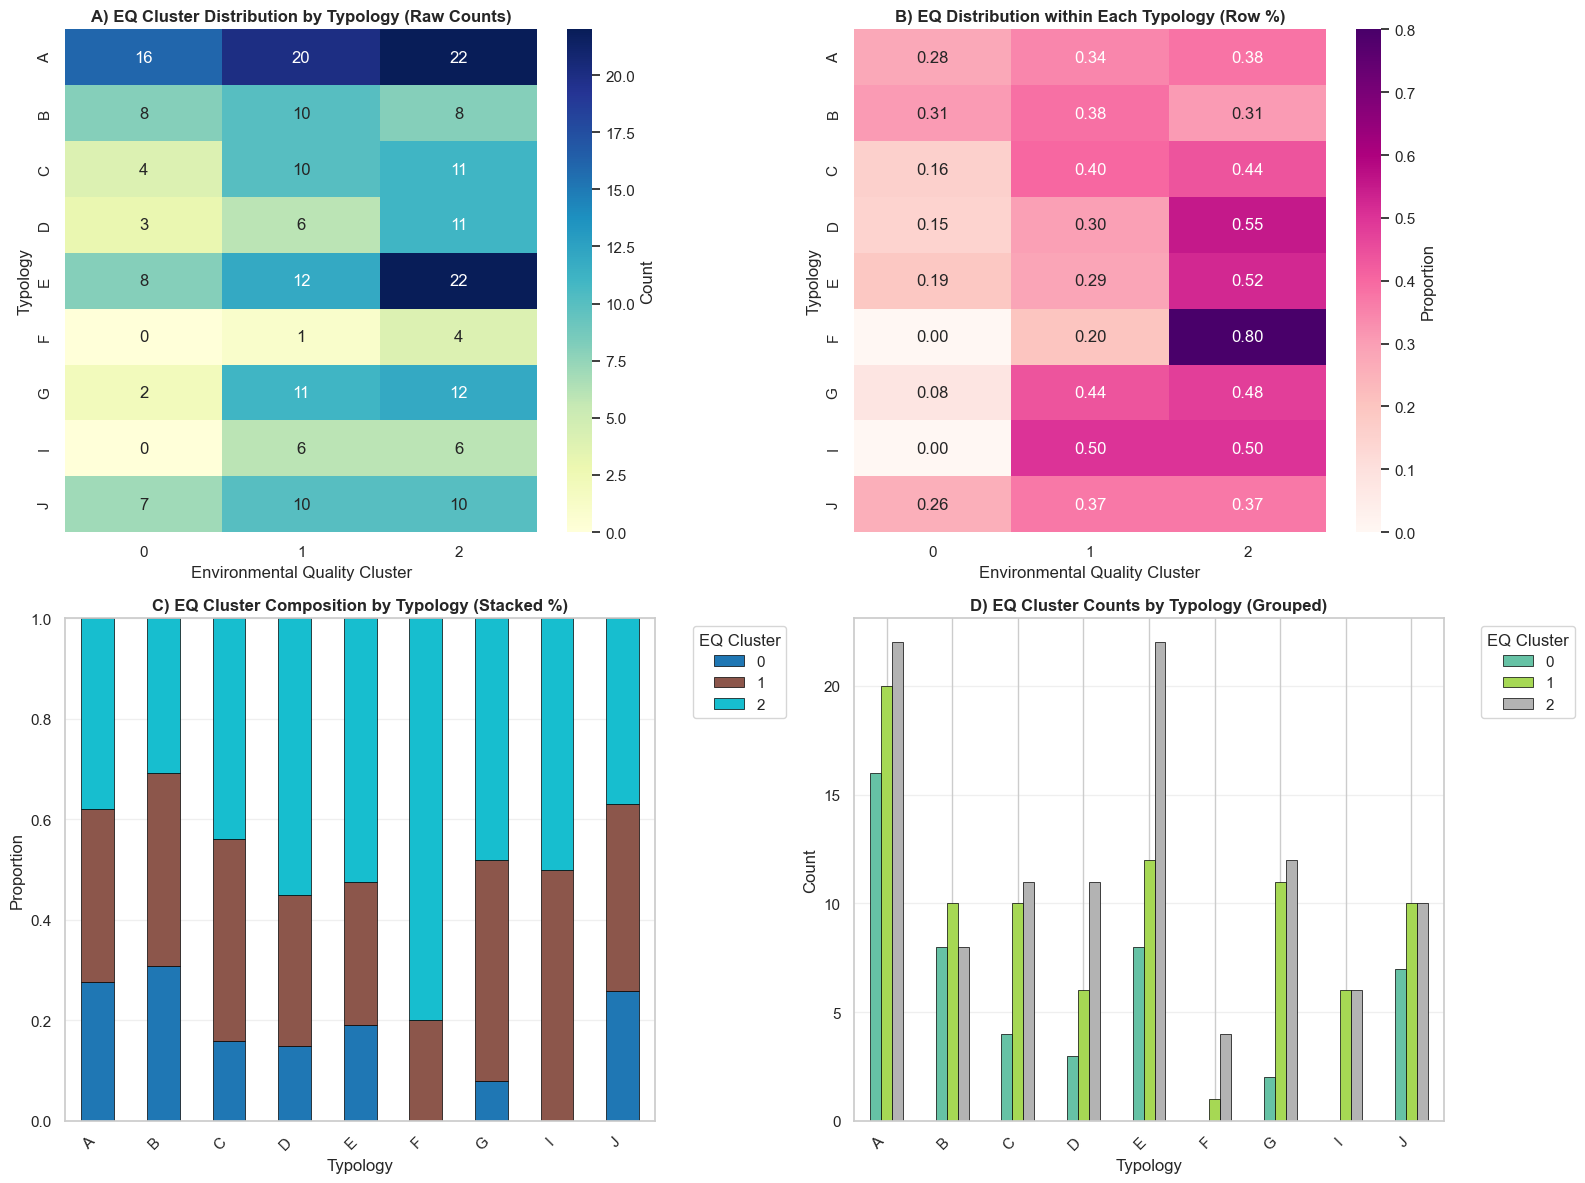

In [29]:
# Cross-tabulation: EQ clusters × Typology
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Check if 'Typology' exists in meta
if 'typology' in meta.columns:
    typology = meta['typology'].values
    
    # Create contingency table
    crosstab_typo = pd.crosstab(
        typology, labels_eq,
        rownames=["typology"],
        colnames=["EQ Cluster"],
        margins=True
    )
    
    print("=== Environmental Quality Distribution by Typology ===")
    display(crosstab_typo)
    
    # Chi-square test
    chi2_typo, p_typo, dof_typo, _ = chi2_contingency(crosstab_typo.iloc[:-1, :-1])
    print(f"\nChi-square test for independence:")
    print(f"  χ² = {chi2_typo:.2f}, p-value = {p_typo:.4f}, dof = {dof_typo}")
    if p_typo < 0.05:
        print("  → Typology and EQ clusters are statistically dependent (p < 0.05)")
    else:
        print("  → No significant association detected")
    
    # Normalized by row (conditional distribution)
    crosstab_typo_norm = crosstab_typo.iloc[:-1, :-1].div(crosstab_typo.iloc[:-1, -1], axis=0)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Panel A: Raw counts heatmap
    sns.heatmap(
        crosstab_typo.iloc[:-1, :-1], annot=True, fmt="d", cmap="YlGnBu",
        ax=axes[0, 0], cbar_kws={"label": "Count"}
    )
    axes[0, 0].set_title("A) EQ Cluster Distribution by Typology (Raw Counts)", fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel("Environmental Quality Cluster")
    axes[0, 0].set_ylabel("Typology")
    
    # Panel B: Row-normalized heatmap (percentage within each typology)
    sns.heatmap(
        crosstab_typo_norm, annot=True, fmt=".2f", cmap="RdPu",
        ax=axes[0, 1], cbar_kws={"label": "Proportion"}
    )
    axes[0, 1].set_title("B) EQ Distribution within Each Typology (Row %)", fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel("Environmental Quality Cluster")
    axes[0, 1].set_ylabel("Typology")
    
    # Panel C: Stacked bar chart (proportions)
    crosstab_typo_norm.plot(
        kind='bar', stacked=True, ax=axes[1, 0],
        colormap='tab10', edgecolor='black', linewidth=0.5
    )
    axes[1, 0].set_title("C) EQ Cluster Composition by Typology (Stacked %)", fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel("Typology")
    axes[1, 0].set_ylabel("Proportion")
    axes[1, 0].legend(title="EQ Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Panel D: Grouped bar chart (side-by-side comparison)
    crosstab_typo.iloc[:-1, :-1].plot(
        kind='bar', ax=axes[1, 1],
        colormap='Set2', edgecolor='black', linewidth=0.5
    )
    axes[1, 1].set_title("D) EQ Cluster Counts by Typology (Grouped)", fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel("Typology")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].legend(title="EQ Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ 'Typology' column not found in meta dataset.")
    print(f"Available columns: {meta.columns.tolist()}")

### 11.2 Statistical Analysis: Which Typologies Have Distinct EQ Patterns?

Identify which typologies show statistically significant associations with specific EQ clusters using post-hoc tests.

=== Standardized Residuals (z-scores) ===
Values > 2 or < -2 indicate significant over/under-representation


EQ Cluster,0,1,2
typology,,,
A,1.29,-0.17,-0.71
B,1.23,0.22,-1.03
C,-0.45,0.35,-0.01
D,-0.50,-0.44,0.73
E,-0.14,-0.79,0.80
F,-1.00,-0.59,1.21
G,-1.34,0.68,0.29
I,-1.55,0.82,0.30
J,0.69,0.10,-0.56



⚠️ No significant associations found at |z| > 2 threshold


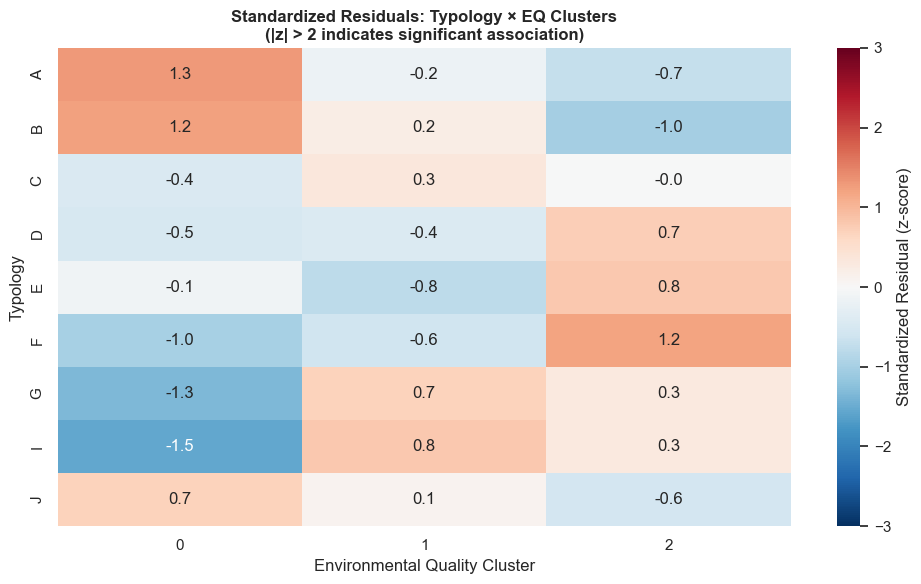

In [31]:
# Statistical analysis of EQ-Typology associations
if 'typology' in meta.columns:
    from scipy.stats import chi2_contingency
    import pandas as pd
    import numpy as np
    
    # Compute standardized residuals (z-scores) for each cell
    # High |z| indicates over/under-representation
    observed = crosstab_typo.iloc[:-1, :-1].values
    chi2, p, dof, expected = chi2_contingency(observed)
    
    # Standardized residuals
    residuals = (observed - expected) / np.sqrt(expected)
    residuals_df = pd.DataFrame(
        residuals,
        index=crosstab_typo.iloc[:-1, :-1].index,
        columns=crosstab_typo.iloc[:-1, :-1].columns
    )
    
    print("=== Standardized Residuals (z-scores) ===")
    print("Values > 2 or < -2 indicate significant over/under-representation")
    display(residuals_df.round(2))
    
    # Identify significant associations
    significant_pairs = []
    for typology_name in residuals_df.index:
        for eq_cluster in residuals_df.columns:
            z_score = residuals_df.loc[typology_name, eq_cluster]
            if abs(z_score) > 2:  # Roughly p < 0.05 threshold
                direction = "over-represented" if z_score > 0 else "under-represented"
                significant_pairs.append({
                    "Typology": typology_name,
                    "EQ Cluster": eq_cluster,
                    "Z-score": z_score,
                    "Direction": direction
                })
    
    if significant_pairs:
        sig_df = pd.DataFrame(significant_pairs).sort_values("Z-score", key=abs, ascending=False)
        print(f"\n=== Significant Associations (|z| > 2) ===")
        display(sig_df)
    else:
        print("\n⚠️ No significant associations found at |z| > 2 threshold")
    
    # Visualize residuals
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(
        residuals_df, annot=True, fmt=".1f", cmap="RdBu_r", center=0,
        vmin=-3, vmax=3, ax=ax,
        cbar_kws={"label": "Standardized Residual (z-score)"}
    )
    ax.set_title("Standardized Residuals: Typology × EQ Clusters\n(|z| > 2 indicates significant association)", 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel("Environmental Quality Cluster")
    ax.set_ylabel("Typology")
    
    # Add significance markers
    for i, typology_name in enumerate(residuals_df.index):
        for j, eq_cluster in enumerate(residuals_df.columns):
            z = residuals_df.loc[typology_name, eq_cluster]
            if abs(z) > 2:
                ax.text(j + 0.5, i + 0.15, '*', ha='center', va='top', 
                       color='black', fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ Typology data not available")

### 11.3 EQ Cluster Profiles within Each Typology

Visualize how environmental features differ within each typology across EQ clusters.

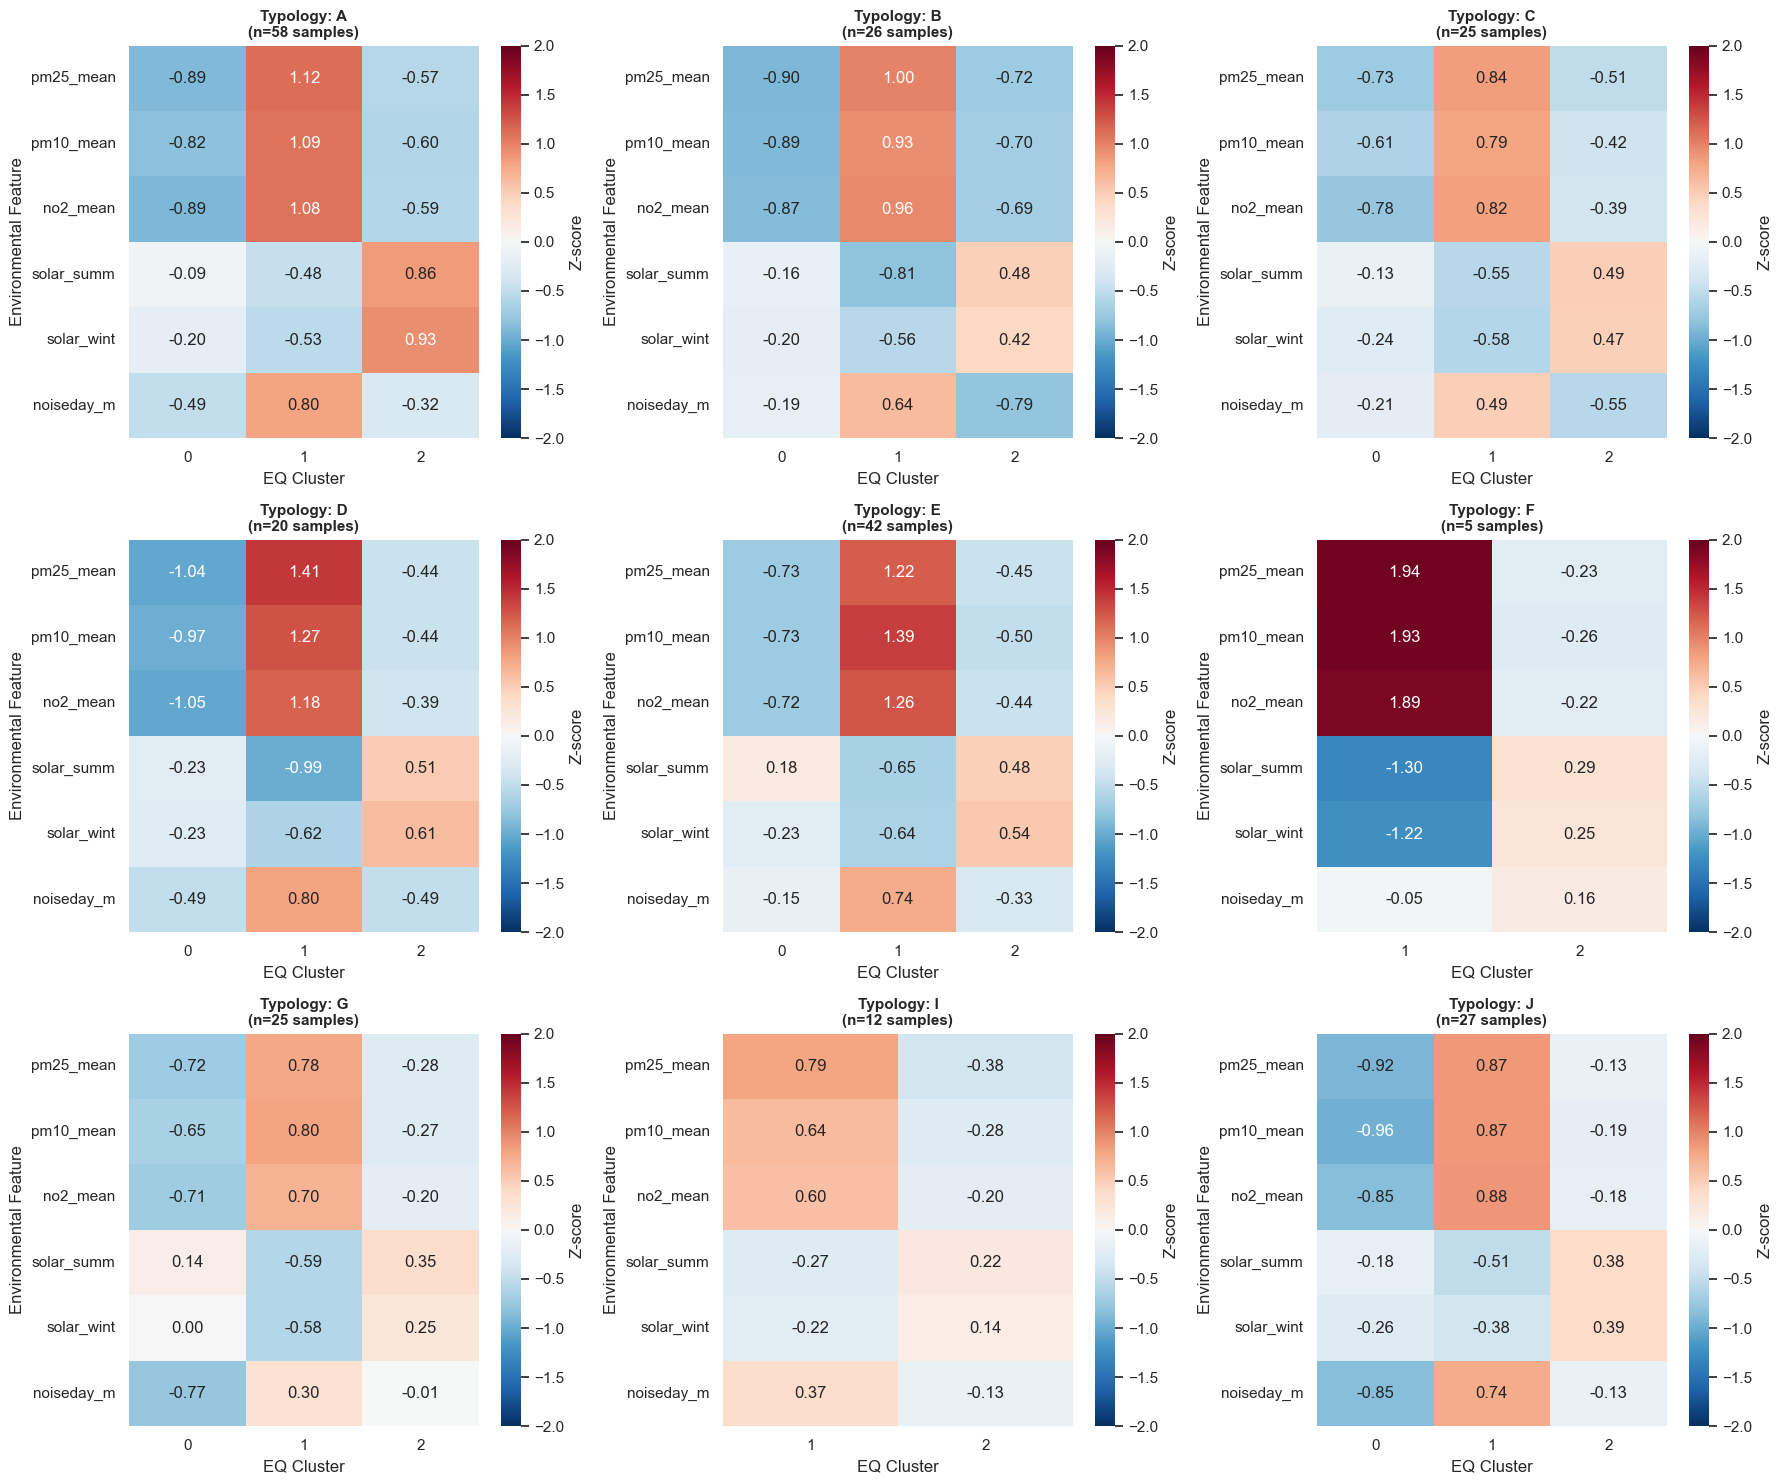


=== EQ Cluster Distribution Summary by Typology ===


,n_samples,n_unique_EQ,most_common_EQ
Typology,,,
A,58,3,2
E,42,3,2
J,27,3,1
B,26,3,1
C,25,3,2
G,25,3,2
D,20,3,2
I,12,2,1
F,5,2,2


In [33]:
# Environmental profiles stratified by typology
if 'typology' in meta.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    
    # Combine data
    X_full = X.copy()
    X_full['EQ_Cluster'] = labels_eq
    X_full['Typology'] = typology
    
    # Get unique typologies
    unique_typos = sorted(X_full['Typology'].unique())
    n_typos = len(unique_typos)
    
    # Select top discriminative environmental features (from earlier analysis)
    if 'env_sig' in locals():
        top_features = env_sig.nsmallest(6, 'p_value')['feature'].tolist()
    else:
        # Fallback: use first 6 features
        top_features = X.columns[:6].tolist()
    
    # Create subplots: one per typology
    n_cols = min(3, n_typos)
    n_rows = (n_typos + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_typos == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_typos > 1 else [axes]
    
    for idx, typo in enumerate(unique_typos):
        ax = axes[idx]
        
        # Filter data for this typology
        typo_data = X_full[X_full['Typology'] == typo]
        
        # Compute mean Z-scores for each EQ cluster within this typology
        profiles = typo_data.groupby('EQ_Cluster')[top_features].mean()
        
        if len(profiles) > 0:
            # Plot heatmap
            sns.heatmap(
                profiles.T, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                ax=ax, cbar_kws={"label": "Z-score"},
                vmin=-2, vmax=2
            )
            ax.set_title(f"Typology: {typo}\n(n={len(typo_data)} samples)", 
                        fontsize=11, fontweight='bold')
            ax.set_xlabel("EQ Cluster")
            ax.set_ylabel("Environmental Feature")
        else:
            ax.text(0.5, 0.5, f"No data for\n{typo}", ha='center', va='center')
            ax.axis('off')
    
    # Hide unused subplots
    for idx in range(n_typos, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n=== EQ Cluster Distribution Summary by Typology ===")
    summary_stats = X_full.groupby('Typology')['EQ_Cluster'].agg([
        ('n_samples', 'count'),
        ('n_unique_EQ', 'nunique'),
        ('most_common_EQ', lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan)
    ]).sort_values('n_samples', ascending=False)
    display(summary_stats)
    
else:
    print("⚠️ Typology data not available")